**Importing necessary Libraries**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-v0_8-white')

from tensorflow.keras.utils import plot_model
import random
from PIL import Image
import glob
import seaborn as sns
from tqdm.notebook import tqdm
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,auc, accuracy_score, confusion_matrix, classification_report

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

**Mounting Drive**

In [ ]:
from google.colab import drive
#drive.mount('provide path to mount drive')

Mounted at /content/drive


**Loading Dataset**

In [ ]:
#train_path = "provide the specified path in drive"
#test_path = "provide the specified path in drive"

classes = ['no_tumor','pituitary_tumor', 'meningioma_tumor','glioma_tumor']
#classes.index('no_tumor')

X_train = []
Y_train = []
#Function to load images and assign a class
def load_data(directory):
    for class_name in tqdm(os.listdir(directory),desc=directory):
        class_path = os.path.join(directory, class_name)
        class_label = class_name
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            X_train.append(img)
            Y_train.append(classes.index(class_name))
    return X_train,Y_train
X_train , Y_train = load_data(train_path)
X_train , Y_train = load_data(test_path)


/content/drive/MyDrive/Brain-Tumor-MRI-dataset/Training:   0%|          | 0/4 [00:00<?, ?it/s]

/content/drive/MyDrive/Brain-Tumor-MRI-dataset/Testing:   0%|          | 0/4 [00:00<?, ?it/s]

**Analysing and Pre-processing the Dataset**

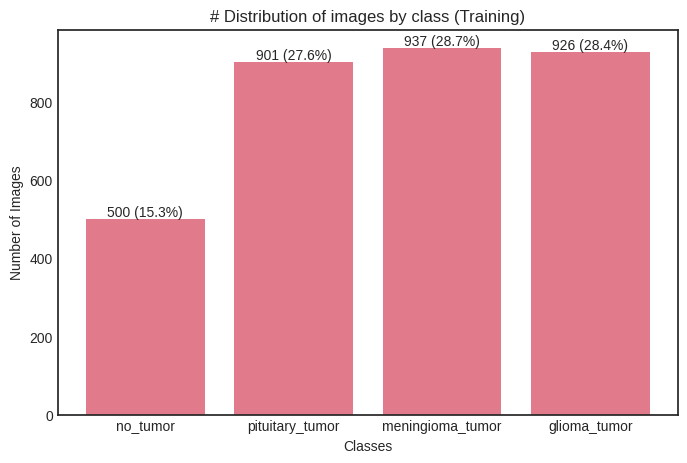

In [ ]:
# Function to count the number of images per class
def count_images_per_class(data, classes):
    count_per_class = {class_name: 0 for class_name in classes}
    for class_idx in data:
        class_name = classes[class_idx]
        count_per_class[class_name] += 1
    return count_per_class

# Count the number of images per class for both the training and testing datasets
train_count_per_class = count_images_per_class(Y_train, classes)

plt.figure(figsize=(8, 5))
#train data
train_bars = plt.bar(train_count_per_class.keys(), train_count_per_class.values(), color='#E17A8A')
plt.title('# Distribution of images by class (Training)')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
#Add the percentages
for bar in train_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height} ({height / np.sum(list(train_count_per_class.values())) * 100:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()

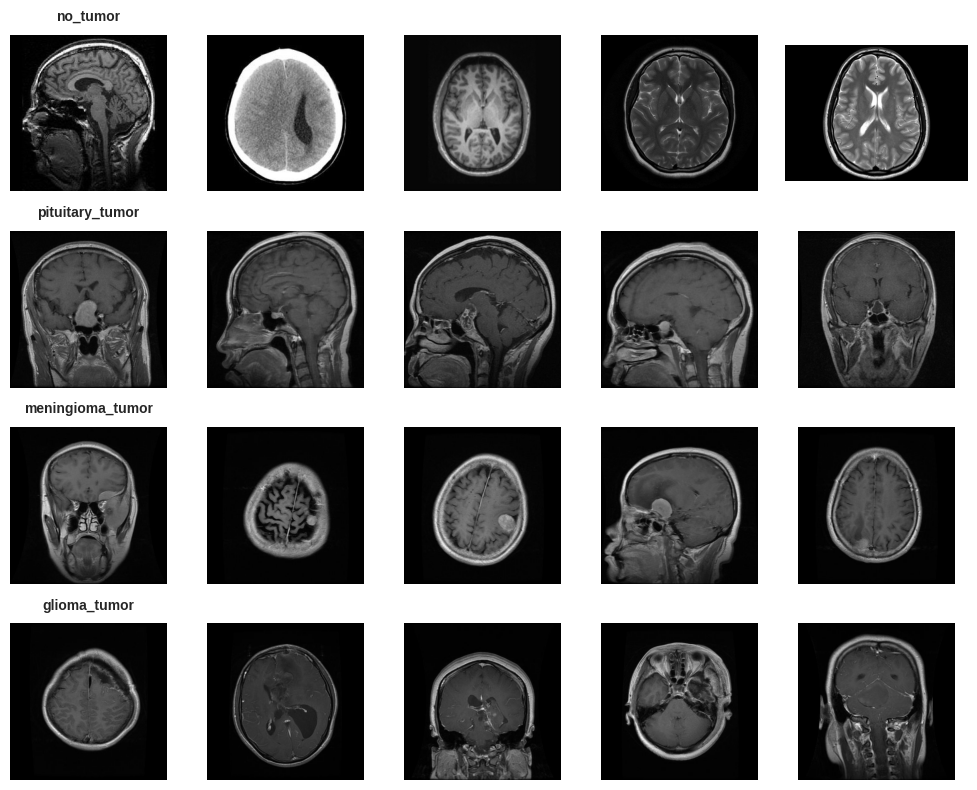

In [ ]:
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Display examples of images for each class
show_examples(X_train, Y_train, classes)

In [ ]:
# Most frequent image sizes
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Count the occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Sort the shapes by number
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# Display the most frequent size
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (512, 512, 3): 2341
- (236, 236, 3): 79
- (225, 225, 3): 43


In [ ]:
shape = (225, 225, 3)

In [ ]:
# Function to crop an image after preprocessing
def preprocess_and_crop_image(image):
    # Convert the image to grayscale
    if len(image.shape) == 3:  # Check if the image is in BGR format
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # if the image is already in grayscale
        gray = image.copy()

    # Convert the image from float32 (range [0, 1]) to uint8 (range [0, 255])
    if gray.dtype == np.float32:
        gray = np.uint8(gray * 255)  # Scale to the range [0, 255]

    # Apply histogram equalization to enhance contrast
    eq_gray = cv2.equalizeHist(gray)

    # Apply global thresholding
    _, global_thresh = cv2.threshold(eq_gray, 127, 255, cv2.THRESH_BINARY)

    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(eq_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                           cv2.THRESH_BINARY, 11, 2)

    # Find contours in the image after adaptive thresholding
    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contour found after thresholding.")
        return image  # Return the original image if no contours are found

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Crop the image according to the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

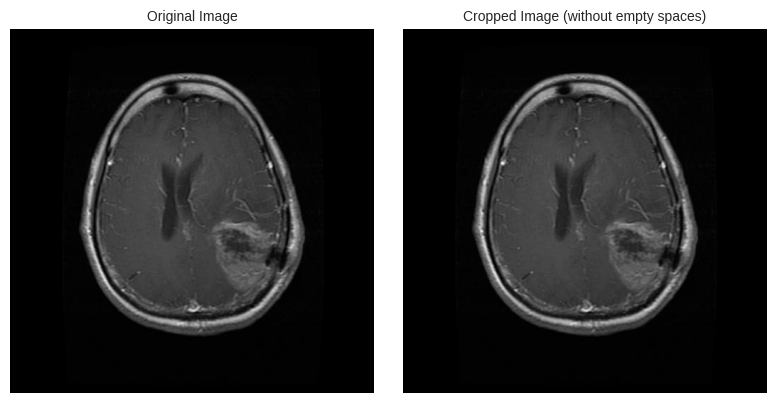

In [ ]:
image_path = "/content/drive/MyDrive/Brain-Tumor-MRI-dataset/Testing/glioma_tumor/image(67).jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Load and crop the image.
cropped_image = preprocess_and_crop_image(img)

# Display the original image and the cropped image.
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Original Image", fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Image (without empty spaces)", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Example function to resize and normalize images
def preprocess_data(train_data, shape=(224, 224)):
    processed_data = []
    for img in tqdm(train_data):
        # Apply the cropping function
        cropped_img = preprocess_and_crop_image(img)

        # Resize the image
        resized_img = cv2.resize(cropped_img, (shape[1], shape[0]))

        # Normalize the image
        normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # Add the preprocessed image to the processed data
        processed_data.append(normalized_img)

    return processed_data

# Preprocess the training data
X_train = preprocess_data(X_train)

# Convert to a NumPy array
X_train = np.array(X_train)

print(f"X_train shape: {np.shape(X_train)}")  # Display the shape of X_train

  0%|          | 0/3264 [00:00<?, ?it/s]

X_train shape: (3264, 224, 224, 3)


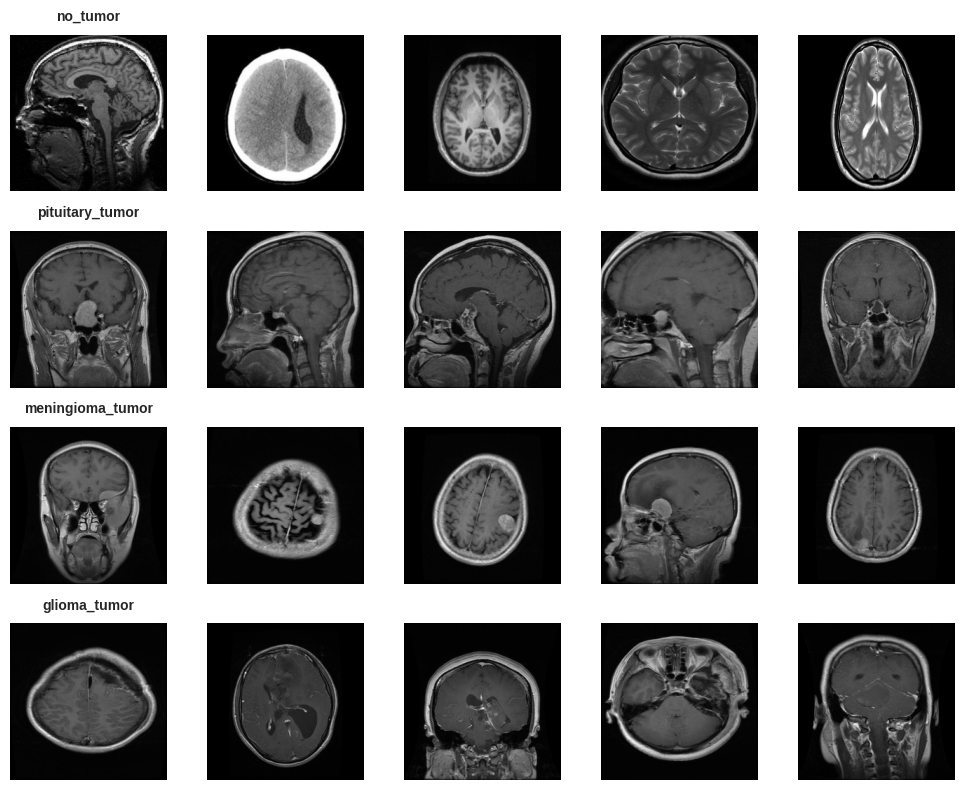

In [ ]:
# Example function to display images from each class
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        # Find the indices for the current class
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]

        # Ensure there are enough examples in the class
        num_class_examples = min(len(class_indices), num_examples)

        # Set the title for the class
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')

        for j in range(num_class_examples):
            img = X_data[class_indices[j]]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')

        # If there are fewer examples than `num_examples`, hide the remaining axes for that class.
        for j in range(num_class_examples, num_examples):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Display example images for each class after preprocessing.
show_examples(X_train, Y_train, classes)


**Splitting the dataset**

In [ ]:
X_train, Y_train = shuffle(X_train,Y_train, random_state=64)

In [ ]:
# Split the training set into training and testing sets.
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=64)

In [ ]:
# Divide the training set into training and test sets.
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test, test_size=2/3,random_state=64)

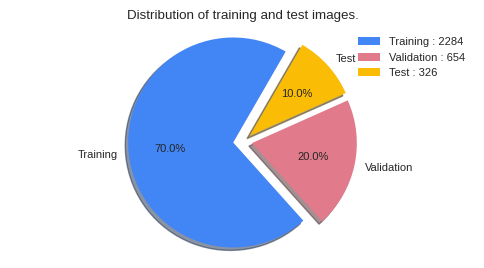

In [ ]:
sizes = [len(Y_train), len(Y_val), len(Y_test)]
labels = ['Training', 'Validation', 'Test']
colors = ['#4285f4', '#E17A8A', '#fbbc05']

plt.figure(figsize=(6,3))
plt.rcParams.update({'font.size': 8})
patches, texts, autotexts = plt.pie(sizes,labels=labels,colors=colors, autopct='%.1f%%', explode=(0.1,0.08,0.08), shadow=True, startangle=60);
plt.title(f"Distribution of training and test images.")
plt.legend(patches, [f"{label} : {size}" for label, size in zip(labels, sizes)], loc="best")
plt.axis('Equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
Y_train =  np.array(tensorflow.keras.utils.to_categorical(Y_train))
Y_val =  np.array(tensorflow.keras.utils.to_categorical(Y_val))
Y_test =  np.array(tensorflow.keras.utils.to_categorical(Y_test))

In [ ]:
# Define the data augmentation parameters.
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow(
    x=np.array(X_train),  # Images
    y=np.array(Y_train) # Labels, converted to one-hot encoding.
)

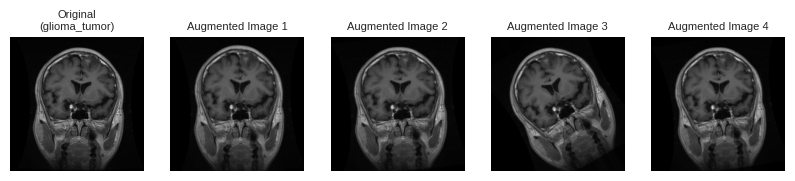

In [ ]:
#Define data augmentation parameters
random_index = np.random.randint(len(X_train))
image = X_train[random_index]
class_label_encoded = Y_train[random_index]
class_label = classes[np.argmax(class_label_encoded)]

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title('Original\n({})'.format(class_label), fontsize=8)
plt.axis('off')

# Generate and display augmented versions of the image
for i in range(4):
    augmented_image = train_datagen.random_transform(image)
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented_image)
    plt.title('Augmented Image {}'.format(i + 1), fontsize=8)
    plt.axis('off')

plt.show()

**Creating and Training the CNN Model**

In [ ]:
CNN_model = Sequential()
CNN_model.add(Conv2D(16, (3,3), activation='relu', input_shape=shape))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(32, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(64, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(512, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(Dropout(0.5))

CNN_model.add(Dense(len(classes), activation='softmax'))


# Compile the model
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
CNN_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 223, 223, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,243,940 (27.63 MB)

 Trainable params: 7,243,940 (27.63 MB)

 Non-trainable params: 0 (0.00 B)

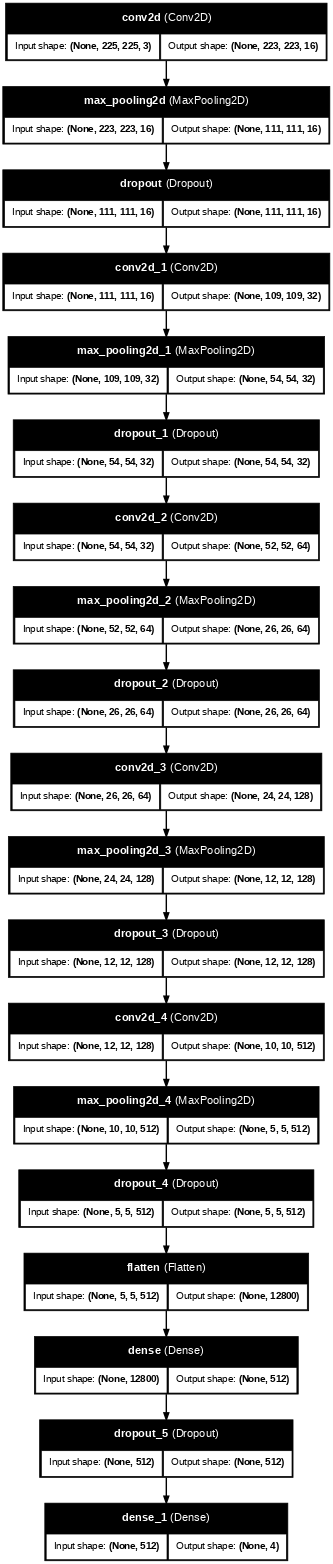

In [ ]:
tensorflow.keras.utils.plot_model(CNN_model,show_shapes=True, show_layer_names=True, dpi=50)

In [ ]:
# Define the batch size
batch_size = 64
# Image shape: height, width, RBG
image_shape = shape
# The number of epochs
epochs = 80

print(f'Batch size: {batch_size}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')

Batch size: 64
Image shape: (225, 225, 3)
Epochs: 80


In [ ]:
# Add ReduceLROnPlateau, EarlyStopping, and checkpoint as callbacks during training
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  # "Stop training early if the validation performance does not improve for a certain number of epochs."
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)  # Save the best model in terms of validation performance.

In [ ]:
# Train the model
import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print("GPU is available")
else:
    print("GPU is not available")

start_time = time.time()
CNN_history = CNN_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)
end_time = time.time()
# End tracking the time
end_time = time.time()

# Calculate and print total training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

GPU is available
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.2929 - loss: 1.4926 - precision: 0.2318 - recall: 0.0214
Epoch 1: val_accuracy improved from -inf to 0.33180, saving model to best_CNNModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - accuracy: 0.2934 - loss: 1.4910 - precision: 0.2338 - recall: 0.0213 - val_accuracy: 0.3318 - val_loss: 1.3208 - val_precision: 0.4378 - val_recall: 0.1453 - learning_rate: 0.0010
Epoch 2/80
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.4641 - loss: 1.1943 - precision: 0.5547 - recall: 0.1326
Epoch 2: val_accuracy improved from 0.33180 to 0.46177, saving model to best_CNNModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - accuracy: 0.4645 - loss: 1.1932 - precision: 0.5549 - recall: 0.1344 - val_accuracy: 0.4618 - val_loss: 1.3593 - val_precision: 0.4758 - val_recall: 0.3150 - learning_rate: 0.0010
Epoch 3/80
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5299 - loss: 1.0608 - precision: 0.5886 - recall: 0.3250
Epoch 3: val_

**Evaluating the Model**

In [ ]:
CNN_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

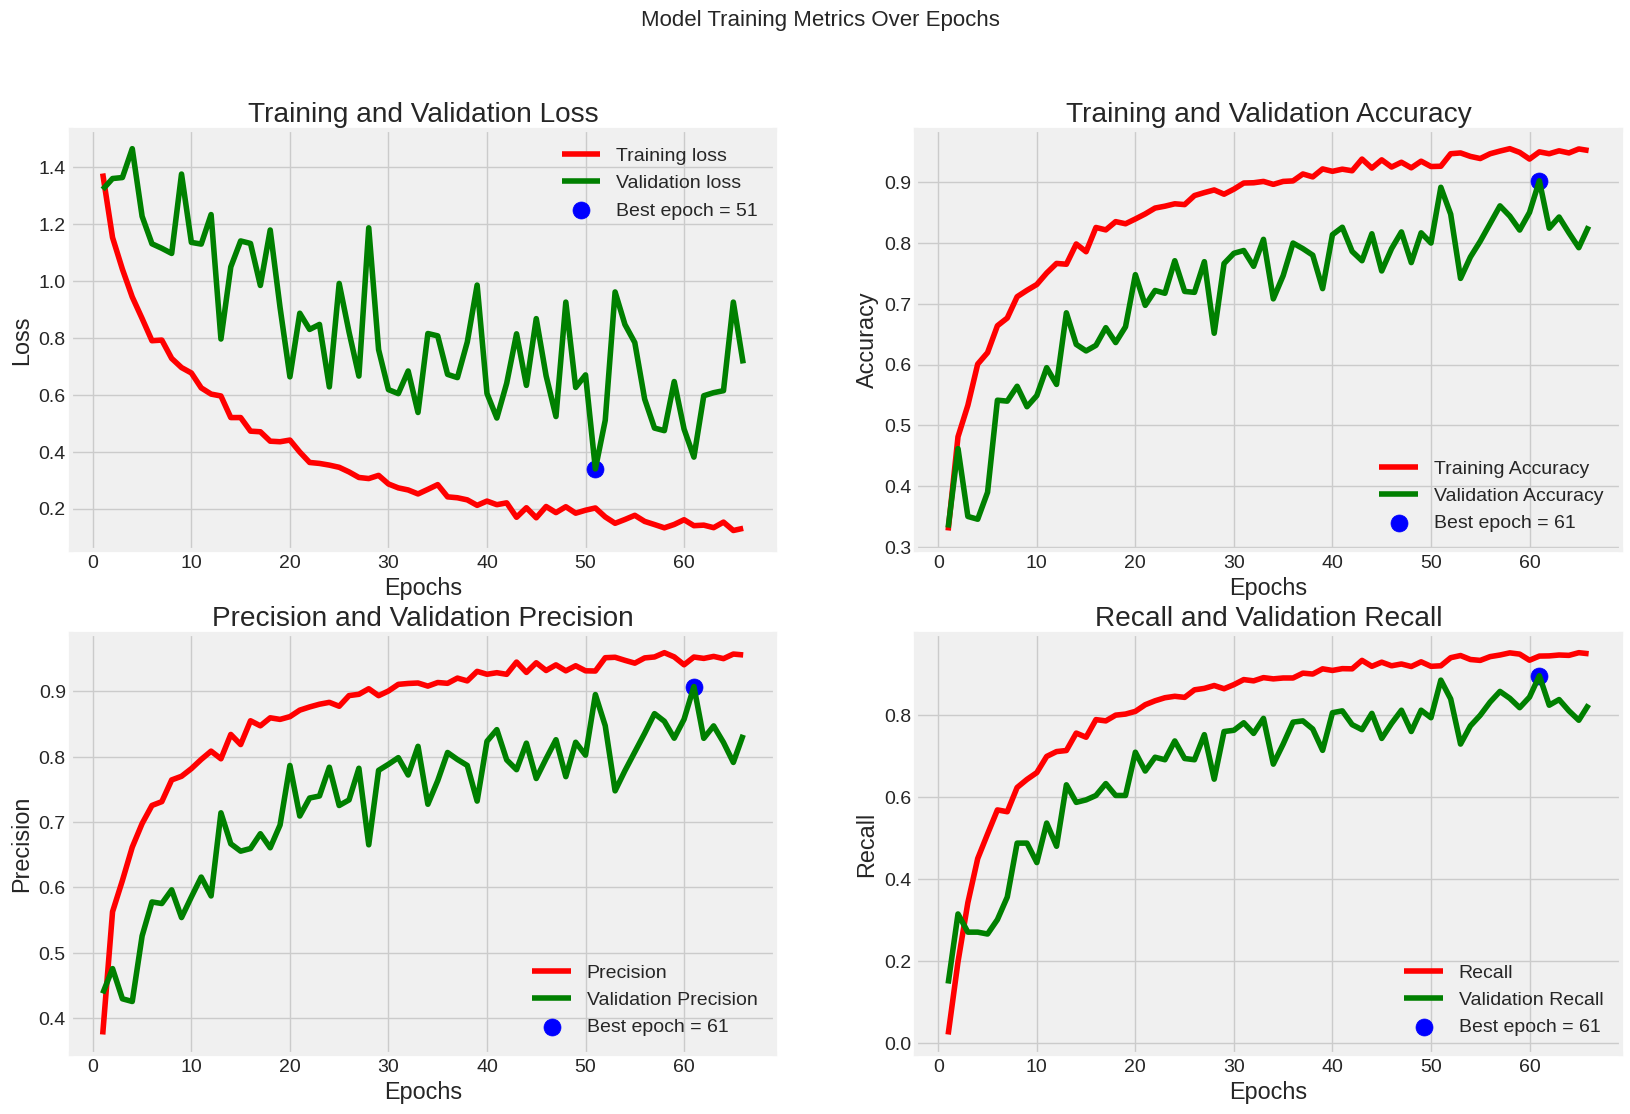

In [ ]:
tr_acc = CNN_history.history['accuracy']
tr_loss = CNN_history.history['loss']
tr_per = CNN_history.history['precision']
tr_recall = CNN_history.history['recall']
val_acc = CNN_history.history['val_accuracy']
val_loss = CNN_history.history['val_loss']
val_per = CNN_history.history['val_precision']
val_recall = CNN_history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
# Evaluate the model on the training set
train_result = CNN_model.evaluate(X_train,Y_train)

# Display the performance metrics
print("Train Loss: {:.2f}%".format(train_result[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result[1] * 100))
print("Train Precision: {:.2f}%".format(train_result[2] * 100))
print("Train Recall: {:.2f}%".format(train_result[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9773 - loss: 0.0766 - precision: 0.9787 - recall: 0.9747
Train Loss: 7.03%
Train Accuracy: 98.07%
Train Precision: 98.15%
Train Recall: 97.81%


In [ ]:
validation_results_cnn = CNN_model.evaluate(X_val,Y_val)

print("Validation Loss: {:.2f}%".format(validation_results_cnn[0] * 100))
print("Validation Accuracy: {:.2f}%".format(validation_results_cnn[1] * 100))
print("Validation Precision: {:.2f}%".format(validation_results_cnn[2] * 100))
print("Validation Recall: {:.2f}%".format(validation_results_cnn[3] * 100))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8831 - loss: 0.3509 - precision: 0.8846 - recall: 0.8740
Validation Loss: 33.93%
Validation Accuracy: 89.14%
Validation Precision: 89.49%
Validation Recall: 88.53%


**Making Predictions using the CNN**

In [ ]:
predictions = CNN_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1)
y_pred_test = np.argmax(predictions, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [ ]:
accuracy = accuracy_score(y_true_test, y_pred_test)
print("Accuracy:{:.2f}%".format(accuracy * 100))

Accuracy:90.49%


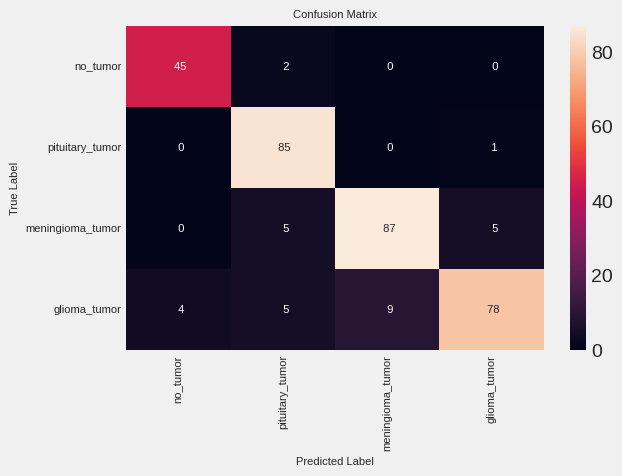

In [ ]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
class_report = classification_report(y_true_test, y_pred_test, target_names=classes)
print("Classification Report:")
print(class_report)

Classification Report:
                  precision    recall  f1-score   support

        no_tumor       0.92      0.96      0.94        47
 pituitary_tumor       0.88      0.99      0.93        86
meningioma_tumor       0.91      0.90      0.90        97
    glioma_tumor       0.93      0.81      0.87        96

        accuracy                           0.90       326
       macro avg       0.91      0.91      0.91       326
    weighted avg       0.91      0.90      0.90       326



## EfficientNet-B0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
shape = (224, 224, 3)

In [ ]:
base_model = EfficientNetB0(include_top=False,
                      input_shape=shape,
                      weights='imagenet')

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

output_tensor = Dense(len(classes), activation='softmax')(x)

EfficientNet_model = Model(inputs=base_model.input, outputs=output_tensor)

EfficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

EfficientNet_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,707,495 (17.96 MB)

 Trainable params: 4,665,472 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
reduce_lr_en = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=0.0001, verbose=1)
#early_stop_en = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint_en = ModelCheckpoint(filepath='best_EfficientNetModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# Check GPU availability
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print("GPU is available")
else:
    print("GPU is not available")

# Train the model
start_time = time.time()
EfficientNet_history = EfficientNet_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr_en, checkpoint_en],
    verbose=1
)
end_time = time.time()
# Calculate and print total training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

GPU is available
Epoch 1/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7240 - loss: 0.7262 - precision_2: 0.8006 - recall_2: 0.6297
Epoch 1: val_accuracy improved from -inf to 0.18043, saving model to best_EfficientNetModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7252 - loss: 0.7238 - precision_2: 0.8013 - recall_2: 0.6315 - val_accuracy: 0.1804 - val_loss: 2.9942 - val_precision_2: 0.1804 - val_recall_2: 0.1804 - learning_rate: 0.0010
Epoch 2/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9061 - loss: 0.2541 - precision_2: 0.9155 - recall_2: 0.8982
Epoch 2: val_accuracy did not improve from 0.18043
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 409ms/step - accuracy: 0.9062 - loss: 0.2540 - precision_2: 0.9155 - recall_2: 0.8983 - val_accuracy: 0.1804 - val_loss: 3.3830 - val_precision_2: 0.1804 - val_recall_2: 0.1804 - learning_rate: 0.0010
Epoch 3/80
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9146 - loss: 0.2596 - precision_2: 0.9244 - recall_2: 0

In [ ]:
EfficientNet_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2', 'learning_rate'])

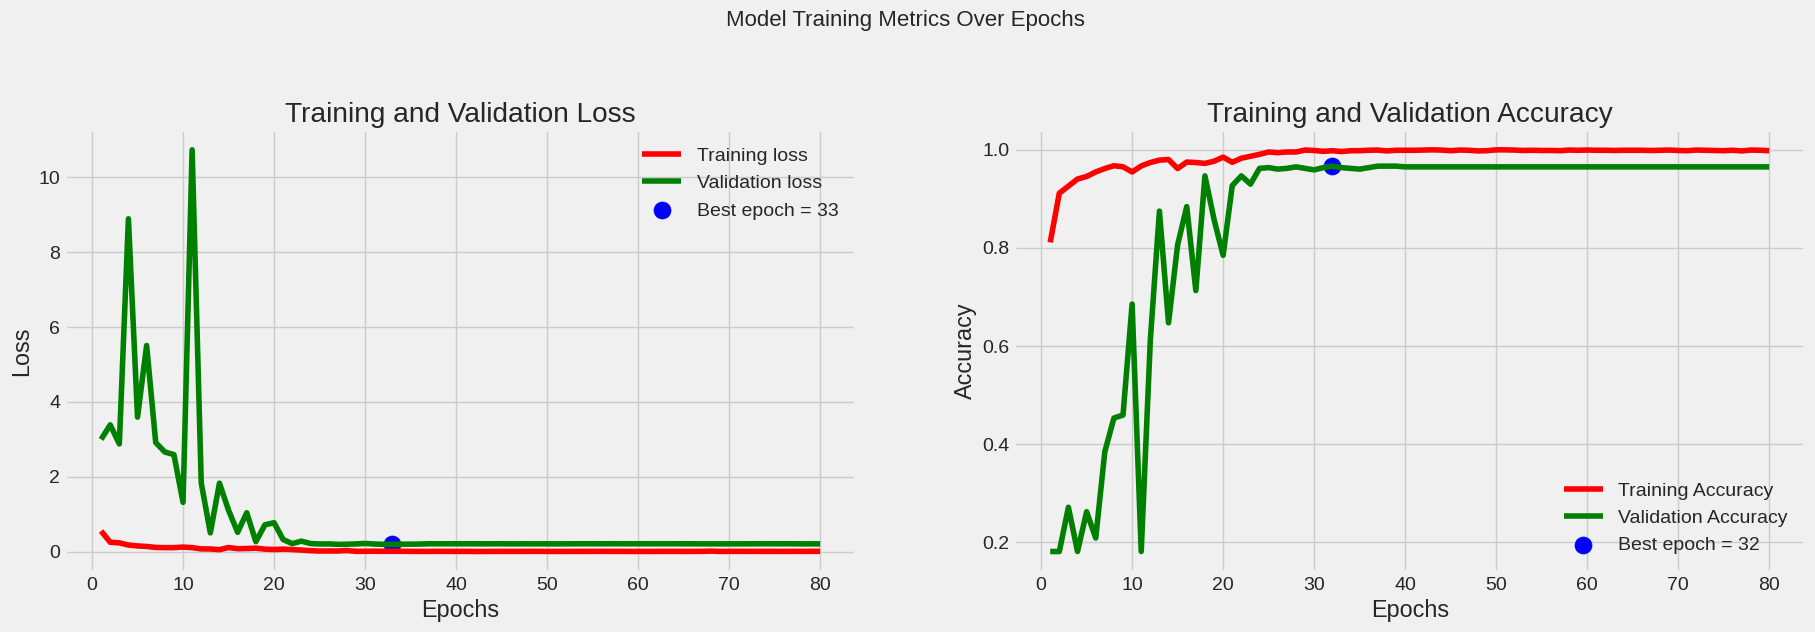

In [ ]:
tr_acc_en = EfficientNet_history.history['accuracy']
tr_loss_en = EfficientNet_history.history['loss']
val_acc_en = EfficientNet_history.history['val_accuracy']
val_loss_en = EfficientNet_history.history['val_loss']

index_loss_en = np.argmin(val_loss_en)
val_lowest_en = val_loss_en[index_loss_en]
index_acc_en = np.argmax(val_acc_en)
acc_highest_en = val_acc_en[index_acc_en]


Epochs = [i + 1 for i in range(len(tr_acc_en))]
loss_label_en = f'Best epoch = {str(index_loss_en + 1)}'
acc_label_en = f'Best epoch = {str(index_acc_en + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss_en, 'r', label='Training loss')
plt.plot(Epochs, val_loss_en, 'g', label='Validation loss')
plt.scatter(index_loss_en + 1, val_lowest_en, s=150, c='blue', label=loss_label_en)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc_en, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc_en, 'g', label='Validation Accuracy')
plt.scatter(index_acc_en + 1, acc_highest_en, s=150, c='blue', label=acc_label_en)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

**Evaluating results**

In [ ]:
train_result_en = EfficientNet_model.evaluate(X_train,Y_train)

print("Train Loss: {:.2f}%".format(train_result_en[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result_en[1] * 100))
print("Train Precision: {:.2f}%".format(train_result_en[2] * 100))
print("Train Recall: {:.2f}%".format(train_result_en[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.9995 - loss: 0.0019 - precision_2: 0.9995 - recall_2: 0.9995
Train Loss: 0.28%
Train Accuracy: 99.87%
Train Precision: 99.87%
Train Recall: 99.87%


In [ ]:
validation_results_en = EfficientNet_model.evaluate(X_test,Y_test)

print("Test Loss: {:.2f}%".format(validation_results_en[0] * 100))
print("Test Accuracy: {:.2f}%".format(validation_results_en[1] * 100))
print("Test Precision: {:.2f}%".format(validation_results_en[2] * 100))
print("Test Recall: {:.2f}%".format(validation_results_en[3] * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - accuracy: 0.9650 - loss: 0.1424 - precision_2: 0.9683 - recall_2: 0.9650
Test Loss: 13.70%
Test Accuracy: 96.32%
Test Precision: 96.62%
Test Recall: 96.32%


**Making Predictions**

In [ ]:
predictions_en = EfficientNet_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1)
y_pred_test_en = np.argmax(predictions_en, axis=1)

accuracy_en = accuracy_score(y_true_test, y_pred_test_en)
print("Accuracy:{:.2f}%".format(accuracy_en * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 663ms/step
Accuracy:96.32%


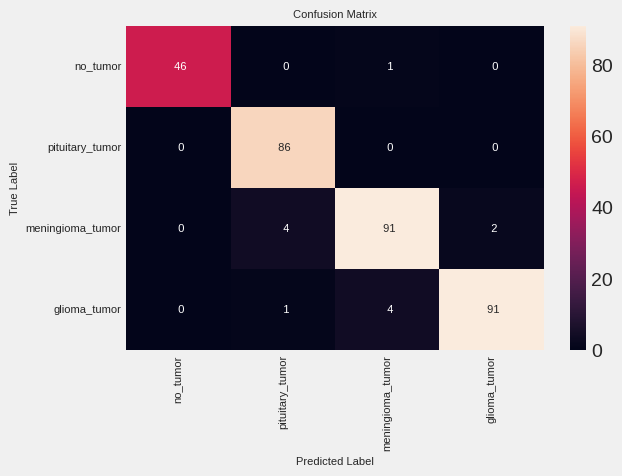

In [ ]:
plt.figure(figsize=(6, 4))
heatmap_en = sns.heatmap(confusion_matrix(y_true_test,y_pred_test_en), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
class_report_en = classification_report(y_true_test, y_pred_test_en, target_names=classes)
print("Classification Report:")
print(class_report_en)

Classification Report:
                  precision    recall  f1-score   support

        no_tumor       1.00      0.98      0.99        47
 pituitary_tumor       0.95      1.00      0.97        86
meningioma_tumor       0.95      0.94      0.94        97
    glioma_tumor       0.98      0.95      0.96        96

        accuracy                           0.96       326
       macro avg       0.97      0.97      0.97       326
    weighted avg       0.96      0.96      0.96       326



**Comparing Results**

In [ ]:
from tabulate import tabulate
import pandas as pd

# Create a dictionary with model names and accuracies
data = {
    "Model": ["Custom CNN", "EfficientNet"],
    "Training Accuracy (%)": [train_result[1] * 100, train_result_en[1] * 100],
    "Validation Accuracy (%)": [validation_results_cnn[1] * 100, validation_results_en[1] * 100],
    "Test Accuracy (%)": [accuracy * 100, accuracy_en * 100],
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(data)

# Round the accuracy values to 2 decimal places
results_df = results_df.round({"Training Accuracy (%)": 2, "Validation Accuracy (%)": 2, "Test Accuracy (%)": 2})

# Print the table
print("Model Evaluation Results:")
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

Model Evaluation Results:
╒══════════════╤═════════════════════════╤═══════════════════════════╤═════════════════════╕
│ Model        │   Training Accuracy (%) │   Validation Accuracy (%) │   Test Accuracy (%) │
╞══════════════╪═════════════════════════╪═══════════════════════════╪═════════════════════╡
│ Custom CNN   │                   98.07 │                     89.14 │               90.49 │
├──────────────┼─────────────────────────┼───────────────────────────┼─────────────────────┤
│ EfficientNet │                   99.87 │                     96.32 │               96.32 │
╘══════════════╧═════════════════════════╧═══════════════════════════╧═════════════════════╛
